# Banknote Authentication Dataset Analysis
**Shiyu Mou**

**shiyumou@usc.edu**

**USCID: 8708001134**

**May 28, 2018**

In [30]:
import numpy as np
import scipy as sp
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
# from sklearn.model_selection import cross_validate

## Preprocessing 

In [4]:
def load_data():   
    filename = "data_banknote_authentication.txt"
    df = pd.read_csv(filename, names=['Variance', 'Skewness', 'Curtosis', 'Entropy', 'Class'])
    X = df.iloc[:, :4]
    y = df["Class"]  
    return df, X, y

In [5]:
df, X, y = load_data()
df.head()

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


### Scatter b(i)


In [6]:
def plotScatter(df):
    color_list = list()
    for i in df["Class"]:
        if i == 1:
            color_list.append('r')
        else:
            color_list.append('b')
    
    pd.plotting.scatter_matrix(df.iloc[:,:4], color=color_list)
    

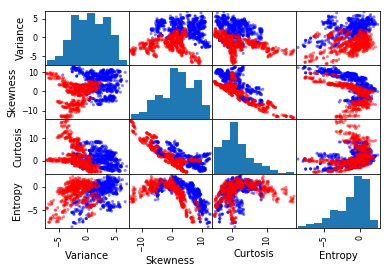

In [7]:
plotScatter(df)

### Boxplot b(ii)

In [8]:
# This method doesn't seperate classes with color
def boxplot(df):   
    df.boxplot(column=['Variance', 'Skewness', 'Curtosis', 'Entropy'], by = 'Class', layout = (2,2))

In [9]:
def boxplot2(df):  
    f, axes = plt.subplots(2, 2)
#     print(axes)
    plt.tight_layout(2)
    ax = sns.boxplot(x=df['Class'], y=df['Variance'], ax=axes[0][0])   
    ax = sns.boxplot(x=df['Class'], y=df['Skewness'], ax=axes[0][1])    
    ax = sns.boxplot(x=df['Class'], y=df['Curtosis'], ax=axes[1][0])    
    ax = sns.boxplot(x=df['Class'], y=df['Skewness'], ax=axes[1][1])

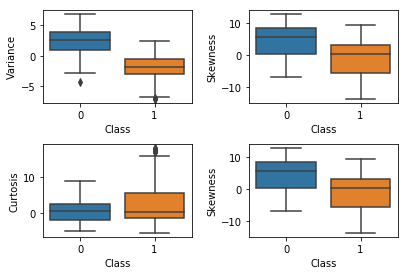

In [10]:
boxplot2(df)

In [11]:
def sliceDataset(df):
    first_non_zero = next((i for i, x in enumerate(df["Class"]) if x==1), None)
    train_df_1 = df.iloc[200:first_non_zero, :]
    train_df_2 = df.iloc[first_non_zero+200:, :]
    train_df = pd.concat([train_df_1, train_df_2])
    test_df_1 = df.iloc[:200, :]
    test_df_2 = df.iloc[first_non_zero:first_non_zero+200, :]
    test_df = pd.concat([test_df_1, test_df_2])
    X_train = train_df.iloc[:, :4]
#     X_train = normalize(X_train)
    y_train = train_df['Class']
    X_test = test_df.iloc[:, :4]
#     X_test = normalize(X_test)
    y_test = test_df['Class']
    return train_df, X_train, y_train, X_test, y_test

In [12]:
def normalize(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    return df

**Notice: It seems like in this case, normalization will make the performance worse**

## Vanila kNN and performance (c)

In [13]:
train_df, X_train, y_train, X_test, y_test = sliceDataset(df)
# X_train, X_test = standardlize(X_train, X_test)
# X_train

In [14]:
def knnClassifier(X_train, y_train, k):

    neigh = KNeighborsClassifier(n_neighbors=k, p=2)
    neigh.fit(X_train, y_train) 

    return neigh

In [15]:
k_list = [i for i in range(1,904,3)]
train_errors = list()
test_errors = list()
for k in k_list:
    model = knnClassifier(X_train, y_train, k)
    train_errors.append(1-model.score(X_train, y_train))
    test_errors.append(1-model.score(X_test, y_test))

index_k = np.argmin(test_errors)
best_k = k_list[index_k]

optimal_list = list()
for i in range(len(k_list)):
    if test_errors[i] == 0.0:
        optimal_list.append(k_list[i])
print("Optimal k is: %s" % best_k)
print("Actually there are many k share same error rate")
print("All the optimal k:", optimal_list)

Optimal k is: 1
Actually there are many k share same error rate
All the optimal k: [1, 4, 7, 10, 13, 16, 19]


In [16]:
def train_test_error(k_list, train_errors, test_errors):
    k_list = np.asarray(k_list)
    inverse_k_list = 1. / k_list

    plt.subplot(1, 1, 1)
    plt.semilogx(inverse_k_list, train_errors, label='Train')
    plt.semilogx(inverse_k_list, test_errors, label='Test')
    plt.vlines(best_k, plt.ylim()[0], np.min(test_errors), color='k',
               linewidth=3, label='Optimum on test')
    plt.legend(loc='upper right')
    plt.ylim([0, 1.2])
    plt.xlabel('1/k')
    plt.ylabel('Error')

## Training error & test error

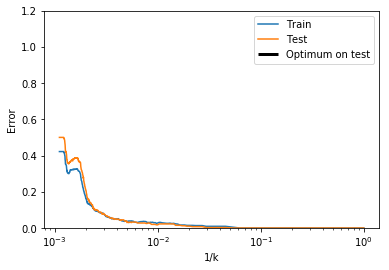

In [17]:
train_test_error(k_list, train_errors, test_errors)

In [18]:
best_model = knnClassifier(X_train, y_train, best_k)
print('Best error rate: ', (1-best_model.score(X_test, y_test)))
pred = best_model.predict(X_test)

Best error rate:  0.0


In [19]:
def summary(model, X_test, y_test, pred):
    confusion_Matrix = confusion_matrix(y_test, pred)
    f1_score = cross_val_score(model, X_test, y_test, cv=10, scoring='f1').mean()
    print('Confusion Matrix', confusion_Matrix)
    print('True positive rate: ', confusion_Matrix[0][0]/200)
    print('True negative rate: ', confusion_Matrix[1][1]/200)
    # Precision = TP/TP+FP
    precision = confusion_Matrix[0][0]/(confusion_Matrix[0][0]+confusion_Matrix[0][1])
    print('Precision: ', precision)
    # Recall = TP/TP+FN
    recall = confusion_Matrix[0][0]/(confusion_Matrix[0][0]+confusion_Matrix[1][0])
    print('Recall: ', recall)
    # F1 Score = 2*(Recall * Precision) / (Recall + Precision)
    print('F-score: ', 2*(recall*precision)/(recall+precision))

In [20]:
summary(best_model, X_test, y_test, pred)

Confusion Matrix [[200   0]
 [  0 200]]
True positive rate:  1.0
True negative rate:  1.0
Precision:  1.0
Recall:  1.0
F-score:  1.0


## Learning Curve

In [21]:
def makeSubset(train_df, n):
    train_df_1 = train_df.iloc[0:int(n/2), :]
    first_one = next((i for i, x in enumerate(train_df["Class"]) if x==1), None)
    train_df_2 = train_df.iloc[first_one:first_one+int(n/2), :]
    train_df_sub = pd.concat([train_df_1, train_df_2])
    X_train_sub = train_df_sub.iloc[:, :4]
    y_train_sub = train_df_sub['Class']
    return X_train_sub, y_train_sub

In [22]:
def plotLearningCurve(train_df, X_test, y_test):
    N_list = [i for i in range(50,801,50)] # 900 doesn't work, class 1 is not enough
    best_error_list = list()
    best_train_error_list = list()
    for n in N_list:
        X_train_sub, y_train_sub = makeSubset(train_df, n)    
        k_list = [i for i in range(1,n,40)]
        train_errors = list()
        test_errors = list()
        for k in k_list:
            model = knnClassifier(X_train_sub, y_train_sub, k)
            train_errors.append(1-model.score(X_train, y_train))
            test_errors.append(1-model.score(X_test, y_test))  
        best_train_error = min(train_errors)
#         print("Lowest training error: ", min(train_errors))
        best_error_rate = min(test_errors)
        best_train_error_list.append(best_train_error)
        best_error_list.append(best_error_rate)
    
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    plt.grid()

    plt.plot(N_list, best_train_error_list, 'o-', color="r",
             label="Training Error")
    plt.plot(N_list, best_error_list, 'o-', color="g",
             label="Test Error")

    plt.legend(loc="best")
   

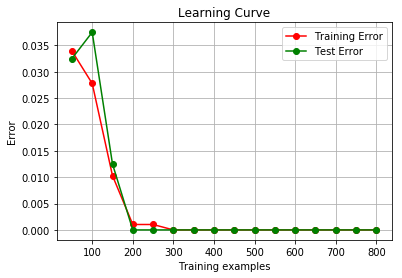

In [23]:
plotLearningCurve(train_df, X_test, y_test)

## Experiments with different distance metrics

In [24]:
def knnClassifier_metric(X_train, y_train, k, metric_, p_):

    neigh = KNeighborsClassifier(n_neighbors=k, p=p_, metric=metric_)
    neigh.fit(X_train, y_train) 

    return neigh

In [25]:
def custom_knn(X_train, y_train, X_test, y_test, metric_, p_):
    k_list = [i for i in range(1,901,10)]
    test_errors = list()
#     train_errors = list()
    for k in k_list:
        model = knnClassifier_metric(X_train, y_train, k, metric_, p_)
        test_errors.append(1-model.score(X_test, y_test))  
#         train_errors.append(model.score(X_train, y_train))
#     print("Lowest training error: ", min(train_errors))
    best_error_rate = min(test_errors)
    index_k = np.argmin(test_errors)
    best_k = k_list[index_k]
    return best_error_rate, best_k

In [26]:
def mahalanobisNN(X_train, y_train, X_test, y_test):
    k_list = [i for i in range(1,901,10)]
    test_errors = list()
#     train_errors = list()
    for k in k_list:
        model = KNeighborsClassifier(algorithm='brute', n_neighbors=3, metric='mahalanobis', 
                                       metric_params={'V': np.cov(X_train)})
        model.fit(X_train, y_train) 
        test_errors.append(1-model.score(X_test, y_test))  
#         train_errors.append(model.score(X_train, y_train))
    best_error_rate = min(test_errors)
#     print("Lowest training error: ", min(train_errors))
    index_k = np.argmin(test_errors)
    best_k = k_list[index_k]
    return best_error_rate, best_k


In [27]:
def disMetricTable(X_train, y_train, X_test, y_test):
    # Manhattan
    t_error_table = dict()
    best_error_rate, best_k = custom_knn(X_train, y_train, X_test, y_test, 'minkowski', 1)
    t_error_table['Manhattan'] = best_error_rate    
    
    # log10(p) ∈ {0.1,0.2,0.3,...,1}
    log_list = [i/10 for i in range(1,11,1)]
    log_errors_list = list()
    for p in log_list:
        model = knnClassifier_metric(X_train, y_train, best_k, 'minkowski', 10**p)
        log_errors_list.append(1-model.score(X_test, y_test))  
    best_log_error_rate = min(log_errors_list)
    index_k_log = np.argmin(log_errors_list)
    print('list of test errors in terms of log(p): ', log_errors_list)
    best_log = log_list[index_k_log]
#     print('Errors when log(p): ', log_errors_list)
    t_error_table['log(p)'] = best_log_error_rate
    
    # Chebyshev Distance
    best_error_rate_cheb, best_k_cheb = custom_knn(X_train, y_train, X_test, y_test, 'chebyshev', None)
    t_error_table['chebyshev'] = best_error_rate_cheb
    
    # mahalanobis
    best_error_rate_maha, best_k_maha = mahalanobisNN(X_train, y_train, X_test, y_test)
    t_error_table['mahalanobis'] = best_error_rate_maha   
    t_error_table = pd.DataFrame.from_dict(data=t_error_table, orient='index')
    return t_error_table

In [33]:
t_error_table = disMetricTable(X_train, y_train, X_test, y_test)
t_error_table.columns = ['Error']
print('log10(p) ∈ {0.1,0.2,0.3,...,1}, every p gives us the same test error\n')
print("Error Table of Different Distance Metrics")
t_error_table

list of test errors in terms of log(p):  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
log10(p) ∈ {0.1,0.2,0.3,...,1}, every p gives us the same test error

Error Table of Different Distance Metrics


,Error
log(p),0.000
Manhattan,0.000
chebyshev,0.000
mahalanobis,0.005


## Weighted Nearest Neighbors

In [66]:
def w_knnClassifier_metric(X_train, y_train, k, metric_, p_):

    neigh = KNeighborsClassifier(n_neighbors=k, weights='distance', p=p_, metric=metric_)
    neigh.fit(X_train, y_train) 

    return neigh

In [67]:
def w_custom_knn(X_train, y_train, X_test, y_test, metric_, p_):
    k_list = [i for i in range(1,901,10)]
    test_errors = list()
    for k in k_list:
        model = w_knnClassifier_metric(X_train, y_train, k, metric_, p_)
        test_errors.append(1-model.score(X_test, y_test))  
    best_error_rate = min(test_errors)
    index_k = np.argmin(test_errors)
    best_k = k_list[index_k]
    return best_error_rate, best_k

In [68]:
def disMetricTable(X_train, y_train, X_test, y_test):
    # Manhattan
    t_error_table = dict()
    best_error_rate_man, best_k_man = w_custom_knn(X_train, y_train, X_test, y_test, 'minkowski', 1)
    t_error_table['Manhattan'] = best_error_rate_man    
    
    # Euclidean
    best_error_rate_Eu, best_k_Eu = w_custom_knn(X_train, y_train, X_test, y_test, 'minkowski', 2)
    t_error_table['Euclidean'] = best_error_rate_Eu  
    
    # Chebyshev Distance
    best_error_rate_cheb, best_k_cheb = w_custom_knn(X_train, y_train, X_test, y_test, 'chebyshev', None)
    t_error_table['chebyshev'] = best_error_rate_cheb
    
    t_error_table = pd.DataFrame.from_dict(data=t_error_table, orient='index')
    return t_error_table 

In [70]:
print("Error Table with Weighted Nearest Neighbors")
weighted_error_table = disMetricTable(X_train, y_train, X_test, y_test)
weighted_error_table.columns = ['Error']
weighted_error_table

Error Table with Weighted Nearest Neighbors


,Error
chebyshev,0.0
Manhattan,0.0
Euclidean,0.0


## Lowest Training Error

As it was shown in the Learning Curve, the lowest training error we got is 0. 